In [ ]:
pip install keras-resnet

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Input, Concatenate, Reshape, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image, ImageDraw
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

import os, math, keras
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as KB
import matplotlib.pyplot as plt
import keras_resnet.models
import gdown

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Global parameters

In [ ]:
# Dictionary of parameters for generating anchors
AnchorParameters = {
    'sizes'   : [32, 64, 128, 256, 512],
    'strides' : [8, 16, 32, 64, 128],
    'ratios'  : np.array([0.5, 1, 2], dtype= 'float32'),
    'scales'  : np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)], dtype = 'float32')
} 

num_anchors = len(AnchorParameters['ratios']) * len (AnchorParameters['scales']) # Number of anchors
name_classes = ['Airplane'] # Names of classes
num_classes = len(name_classes) # Number of classes
input_shape = (416, 416, 3) # Input image shape
path = '/content/drive/My Drive/Самолеты/' # Path to image folder

# Model creation

## Functions

In [ ]:
# Creating a classifier model
def create_classifier(
        size_in = 256,     # Input shape for the classifier
        size_conv2D = 256, # Number of neurons in the Conv2D layers of the classifier     
        ):
    inputs = Input(shape = (None, None, size_in)) # Input layer for the classifier
    x = inputs # Copy the input layer into the x variable
    for i in range(4): # Create four Conv2D layers one by one
        x = Conv2D(size_conv2D, kernel_size = 3, strides = 1, padding = 'same',                 
                   activation = 'relu', name = 'classifier_level_{}'.format(i),
                   kernel_initializer = tf.compat.v1.keras.initializers.normal(
                                           mean = .0, stddev = .01,seed = None),
                   bias_initializer = 'zero'
                  ) (x)
    
    # Add the last classifier layer with the number of neurons num_classes * num_anchors
    x = Conv2D(num_classes * num_anchors, kernel_size = 3, strides = 1, padding = 'same',
               name = 'classifier_top_level', kernel_initializer = tf.compat.v1.keras.initializers.normal(
                                                                        mean = .0, stddev = .01,seed = None),
                   bias_initializer = 'zero'     
              ) (x)
    x = Reshape((-1, num_classes), name = 'classifier_reshape') (x) # Reshape
    outputs = Activation('sigmoid', name = 'classifier_sigmoid') (x) # Add sigmoid activation
    
    return Model(inputs = inputs, outputs = outputs, name = 'classifier') # The function returns Model

In [ ]:
# Regression model
def create_regressor(        
        size_in = 256,     
        size_Conv2D = 256, 
        ):
    num_param = 4 # Number of parameters (4 coordinates (xmin, ymin, xmax, ymax))
    inputs = Input(shape = (None, None, size_in)) # Create an input layer for the regression model
    x = inputs # 
    for i in range(4): # 
        x = Conv2D(size_Conv2D, kernel_size = (3,3) , strides = 1, padding = 'same',
                   activation='relu', name = 'regressor_level_{}'.format(i),
                   kernel_initializer = tf.compat.v1.keras.initializers.normal (
                                            mean = .0, stddev = .01, seed = None),
                   bias_initializer = 'zeros'
                  ) (x)
        
    # Add the last classifier layer with the number of neurons num_classes * num_param
    x = Conv2D (num_anchors * num_param, kernel_size = 3, strides = 1, padding = 'same',
                activation = 'relu', name = 'regressor_top_level',
                kernel_initializer = tf.compat.v1.keras.initializers.normal (
                                            mean = .0, stddev = .01, seed = None),
                bias_initializer = 'zeros'
               ) (x)
    outputs = Reshape((-1, num_param), name = 'regressor_reshape') (x) 
        
    return Model (inputs = inputs, outputs = outputs, name = 'regressor') 

In [ ]:
# Own class of the layer that reshapes from one level of the pyramid to another
class LayerToUpLevel(keras.layers.Layer):    
    def call(self, x):
        data_in, data_out = x # Get the data from the two layers fed to the input
        
        # Return changed data
        return tf.compat.v1.image.resize_images(
                    data_in, (KB.shape(data_out)[1], KB.shape(data_out)[2]),
                    tf.image.ResizeMethod.NEAREST_NEIGHBOR,
                    False
        )
        
    # Override the compute_output_shape method
    def compute_output_shape(self, input_shape):
        '''
            Return the new shape of the layer, where
            0-th element is equal to batch_size (input_shape[0][0])
            1st, 2nd elements are equal to the new layer shape (input_shape[1][1:3])
            3rd element is equal to the depth of the image (input_shape[0][-1])
        '''
        return (input_shape[0][0],) + input_shape[1][1:3] + (input_shape[0][-1],)

In [ ]:
def create_pyramid(
        levels, #
        size_in = 256 
        ):

    level_out_3 = Conv2D(size_in, kernel_size = 1, strides = 1, 
                         padding = 'same', name = 'OUT_3_0'
                        ) (levels[2])    

    layer_toLIN2 = LayerToUpLevel(name = 'L3to2') ([level_out_3, levels[1]]) 

    level_out_3 = Conv2D(size_in, kernel_size = 3, strides = 1, 
                         padding = 'same', name = 'OUT_3'
                        ) (level_out_3)   


    level_out_2 = Conv2D(size_in, kernel_size = 1, strides = 1, 
                         padding = 'same', name = 'OUT_2_0'
                        ) (levels[1])

    level_out_2 = Add(name = 'Add22')([layer_toLIN2, level_out_2])

    layer_toLIN1 = LayerToUpLevel(name = 'L2to1') ([level_out_2, levels[0]])

    level_out_2 = Conv2D(size_in, kernel_size = 3, strides = 1,
                         padding = 'same', name = 'OUT_2'
                        ) (level_out_2)
    

    level_out_1 = Conv2D(size_in, kernel_size = 1, strides = 1,
                         padding = 'same', name = 'OUT_1_0'
                        ) (levels[0])

    level_out_1 = Add(name = 'Add11') ([layer_toLIN1, level_out_1 ])

    level_out_1 = Conv2D(size_in, kernel_size = 3, strides = 1,
                         padding = 'same', name = 'OUT_1'
                        ) (level_out_1)

    level_out_4 = Conv2D(size_in, kernel_size = 3, strides = 2,
                         padding = 'same', name = 'OUT_4'
                        ) (levels[2])
    

    level_out_5 = Activation('relu')(level_out_4)
    level_out_5 = Conv2D(size_in, kernel_size = 3, strides = 2,
                         padding = 'same', name = 'OUT_5'
                        ) (level_out_5)  
    return [level_out_1, level_out_2, level_out_3, level_out_4, level_out_5]

In [ ]:
# Create a RetinaNet model
def create_retinanet(
        inputs,
        base_layers # Output layers of the base model
        ):
    regressor = create_regressor() 
    classifier = create_classifier() 
    pyramid = create_pyramid(base_layers) 

    outputs1 = Concatenate(axis = 1, name = regressor.name + '_model') ([regressor(f) for f in pyramid]) 
    outputs2 = Concatenate(axis = 1, name = classifier.name + '_model') ([classifier(f) for f in pyramid]) 
    
    return Model (inputs = inputs, outputs = [outputs1, outputs2], name = 'RetinaNet')
    

In [ ]:
inputs = Input(shape = input_shape) # Input shape for the ResNet50 model

resnet_model = keras_resnet.models.ResNet50(inputs, include_top=False, freeze_bn=True) 

In [ ]:
resnet_model.output

[<KerasTensor: shape=(None, 104, 104, 256) dtype=float32 (created by layer 'res2c_relu')>,
 <KerasTensor: shape=(None, 52, 52, 512) dtype=float32 (created by layer 'res3d_relu')>,
 <KerasTensor: shape=(None, 26, 26, 1024) dtype=float32 (created by layer 'res4f_relu')>,
 <KerasTensor: shape=(None, 13, 13, 2048) dtype=float32 (created by layer 'res5c_relu')>]

In [ ]:
# Create the RetinaNet model. Take the last three layers of the ResNet50 model as input layers
retinanet_model = create_retinanet(inputs, base_layers = resnet_model.outputs[1:4])

In [ ]:
retinanet_model.input

<KerasTensor: shape=(None, 416, 416, 3) dtype=float32 (created by layer 'input_19')>

In [ ]:
retinanet_model.outputs

[<KerasTensor: shape=(None, 32526, 4) dtype=float32 (created by layer 'regressor_model')>,
 <KerasTensor: shape=(None, 32526, 1) dtype=float32 (created by layer 'classifier_model')>]

In [ ]:
retinanet_model.summary()

Model: "RetinaNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 208, 208, 64  9408        ['input_19[0][0]']               
                                )                                                                 
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 208, 208, 64  256         ['conv1[0][0]']                  
                                )                                                         

# Model training

In [ ]:
# Random image generator
def data_generator(dictionary, batch_size):
    n = len(dictionary) 
    i = 0 
    while True:        
        image_data = [] 
        box_data = [] 
        for b in range(batch_size): 
            if i==0: 
                np.random.shuffle(dictionary)

            image, box = augmentation(dictionary[i])
            image_data.append(image) 
            box_data.append(box) 
            i = (i+1) % n 
        x = np.array(image_data) 
        box_data = np.array(box_data) 
        y = get_y(x, box_data) 
        yield x,y

In [ ]:
# Getting a random number
def rand(a = 0, b = 1):
    return np.random.rand()*(b-a) + a

In [ ]:
# Airplane image parsing functions

# Get the bounding box coordinates
def getXY(image):
    image_red = np.array(image)[:,:,0]  # Read the red image channel
    indexes = np.where(image_red > 20) # Get the indexes of red pixels
    
    # Return the bounding box coordinates [Xmin, Ymin, Xmax, Ymax]
    return [min(indexes[1]), min(indexes[0]), max(indexes[1]), max(indexes[0]) ]

# Creating a dictionary {File name: file parameters}
def get_dict():
    dictionary = {} 
    files = os.listdir(path + 'Segment/') # File list
    class_id = 0 
    for f in files:
        image = Image.open(path+'Segment/'+f) 
        xy = getXY(image) 
        key = f 

        dictionary[key] = 'Самолеты/' + key+' ' +str (xy[0]) +',' + str(xy[1])+','+str(xy[2])+','+str(xy[3])+','+str(class_id)
    print ('Class processing completed: ', name_classes[0]) 
        
    return dictionary 

In [ ]:
# Random image augmentation
def augmentation(data):

    params = {
        'jitter' : .3,
        'hue'    : .1,
        'sat'    : 1.5,
        'val'    : 1.5
    }
    
    data = data.split() 
    image = Image.open(path + data[0]) 
    width_i, height_i = image.size 
    widht_shape, height_shape = input_shape[:2] 

    box = np.array([np.array(list(map(lambda x: int(float(x)),box.split(',')))) for box in data[1:]])

    new_ar = widht_shape / height_shape * rand(1 - params['jitter'], 1 + params['jitter']) / rand(1 - params['jitter'], 1 + params['jitter'])
    scale = rand(.25, 2) 
    if new_ar < 1:        
        nh = int(scale * height_shape)
        nw = int(nh * new_ar)
    else:
        nw = int(scale * widht_shape)
        nh = int(nw / new_ar)
    image = image.resize((nw, nh), Image.BICUBIC)
    
    dx = int(rand(0, widht_shape - nw))
    dy = int(rand(0, height_shape - nh))
    new_image = Image.new('RGB', (widht_shape, height_shape), (128,128,128))
    new_image.paste(image, (dx, dy))
    image = new_image
    
    flip = rand() < .5
    if flip:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)

    hue1 = rand(-params['hue'], params['hue'])
    sat1 = rand(1, params['sat']) if rand() < .5 else 1 / rand(1, params['sat'])
    val1 = rand(1, params['val']) if rand() < .5 else 1 / rand(1, params['val'])
    x = rgb_to_hsv(np.array(image) / 255.)
    x[..., 0] += hue1
    x[..., 0][x[..., 0] > 1] -= 1
    x[..., 0][x[..., 0] < 0] += 1
    x[..., 1] *= sat1
    x[..., 2] *= val1
    x[x > 1] = 1
    x[x < 0] = 0
    image_data = hsv_to_rgb(x) 
    
    max_boxes = 4 
    box_data = np.zeros((max_boxes,5)) 
    if len(box)>0:                
        box[:, [0,2]] = box[:, [0,2]] * nw/width_i + dx
        box[:, [1,3]] = box[:, [1,3]] * nh/height_i + dy
        if flip: box[:, [0,2]] = widht_shape - box[:, [2,0]]
        box[:, 0:2][box[:, 0:2]<0] = 0
        box[:, 2][box[:, 2] > widht_shape] = widht_shape
        box[:, 3][box[:, 3] > height_shape] = height_shape
        box_w = box[:, 2] - box[:, 0]
        box_h = box[:, 3] - box[:, 1]
        box = box[np.logical_and(box_w > 1, box_h > 1)]
        if len(box) > max_boxes:
            box = box[:max_boxes]
        box_data[:len(box)] = box
    
    return image_data, box_data
    

In [ ]:
# Calculation of network output
def get_y(
        image_data,
        box_data
        ):
    levels = [3,4,5,6,7] 
    
    image_shapes = [(np.array(input_shape[:2]) + 2 ** x - 1) // (2 ** x) for x in levels] # [52,52], [26,26], [13,13], [7,7], [4,4]
    anchors = np.zeros((0,4)) 
    
    for idx, p in enumerate(levels): 
        sub_anchors = np.zeros((num_anchors, 4)) 

        sub_anchors[:, 2:] = AnchorParameters['sizes'][idx] * np.tile(AnchorParameters['scales'], 
                                                                      (2, len(AnchorParameters['ratios']))).T        
        areas = sub_anchors[:, 2] * sub_anchors[:, 3]         
         
        sub_anchors[:, 2] = np.sqrt(areas / np.repeat(AnchorParameters['ratios'], len(AnchorParameters['scales'])))
        sub_anchors[:, 3] = sub_anchors[:, 2] * np.repeat(AnchorParameters['ratios'], len(AnchorParameters['scales']))  

        sub_anchors[:, 0::2] -= np.tile(sub_anchors[:, 2] * 0.5, (2, 1)).T
        sub_anchors[:, 1::2] -= np.tile(sub_anchors[:, 3] * 0.5, (2, 1)).T

        grid_x = (np.arange(0, image_shapes[idx][1]) + 0.5) * AnchorParameters['strides'][idx]
        grid_y = (np.arange(0, image_shapes[idx][0]) + 0.5) * AnchorParameters['strides'][idx]
        grid_x, grid_y = np.meshgrid(grid_x, grid_y)
        grid = np.vstack((
                            grid_x.ravel(), grid_y.ravel(),
                            grid_x.ravel(), grid_y.ravel()
                          )).transpose()
        A = sub_anchors.shape[0]
        K = grid.shape[0]

        shifted_anchors = (sub_anchors.reshape((1, A, 4)) + grid.reshape((1, K, 4)).transpose((1, 0, 2)))
        shifted_anchors = shifted_anchors.reshape((K * A, 4))

        anchors = np.append(anchors, shifted_anchors, axis = 0)
        
    batch_size = len(image_data) 
    
    y_regressor = np.zeros((batch_size, anchors.shape[0], 4 + 1), dtype = 'float32') 
    y_classifier = np.zeros((batch_size, anchors.shape[0], num_classes + 1), dtype = 'float32') 

    param = {
        'positive' : .5,
        'negative' : .4
    }
    
    for index, (image, box) in enumerate(zip(image_data, box_data)): 
        intersect = np.zeros((anchors.shape[0],box.shape[0])) 
        for k in range(box.shape[0]): 
            box_area = (
                (box[k, 2] - box[k, 0] + 1) *
                (box[k, 3] - box[k, 1] + 1)
            )
            for n in range(anchors.shape[0]): 
                iw = (
                    min(anchors[n, 2], box[k, 2]) -
                    max(anchors[n, 0], box[k, 0]) + 1
                )
                
                if iw > 0: 
                    ih = (
                        min(anchors[n, 3], box[k, 3]) -
                        max(anchors[n, 1], box[k, 1]) + 1
                    )
                    
                    if ih > 0: 
                        ua = np.float64(
                            (anchors[n, 2] - anchors[n, 0] + 1) *
                            (anchors[n, 3] - anchors[n, 1] + 1) +
                            box_area - iw * ih
                        )
                        intersect[n, k] = iw * ih / ua
        argmax_intersect_inds = np.argmax(intersect, axis=1) 
        max_intersect = intersect[np.arange(intersect.shape[0]), argmax_intersect_inds] 
        positive_indices = max_intersect >= param['positive'] 
        negative_indices = (max_intersect > param['negative']) & ~positive_indices 

        y_classifier[index, negative_indices, -1] = -1
        y_classifier[index, positive_indices, -1] = 1
        y_regressor[index, negative_indices, -1] = -1
        y_regressor[index, positive_indices, -1] = 1

        for i in range(positive_indices.shape[0]):
            if (positive_indices[i]):
                y_classifier[index, i, box[argmax_intersect_inds[i]][4].astype(int)] = 1

        y_regressor[index, :, :-1] = get_full_information(anchors, box[:4][argmax_intersect_inds, :])

        anchors_centers = np.vstack([(anchors[:, 0] + anchors[:, 2]) / 2, (anchors[:, 1] + anchors[:, 3]) / 2]).T
        indices = np.logical_or(anchors_centers[:, 0] >= image.shape[1], anchors_centers[:, 1] >= image.shape[0])
        y_classifier[index, indices, -1] = -1
        y_regressor[index, indices, -1] = -1
        
    return list((y_regressor, y_classifier))

In [ ]:
# Get data about all anchors
def get_full_information(
        anchors,
        boxes
        ):
    mean = np.array([0, 0, 0, 0])
    std = np.array([0.2, 0.2, 0.2, 0.2])
    
    anchor_widths  = anchors[:, 2] - anchors[:, 0] 
    anchor_heights = anchors[:, 3] - anchors[:, 1] 

    offset_dx1 = (boxes[:, 0] - anchors[:, 0]) / anchor_widths
    offset_dy1 = (boxes[:, 1] - anchors[:, 1]) / anchor_heights
    offset_dx2 = (boxes[:, 2] - anchors[:, 2]) / anchor_widths
    offset_dy2 = (boxes[:, 3] - anchors[:, 3]) / anchor_heights    

    result = np.stack((offset_dx1, offset_dy1, offset_dx2, offset_dy2))
    result = result.T
    
    result = (result - mean) / std 
    
    return result

In [ ]:
# Loss functions

# Regression model loss function
def smooth_l1(sigma=3.0):
    sigma_squared = sigma ** 2

    def _smooth_l1(y_true, y_pred):
        regression        = y_pred 
        regression_target = y_true[:, :, :-1] 
        anchor_state      = y_true[:, :, -1]

        indices           = tf.where(KB.equal(anchor_state, 1)) 
        regression        = tf.gather_nd(regression, indices) 
        regression_target = tf.gather_nd(regression_target, indices) 

        regression_diff = regression - regression_target 
        regression_diff = KB.abs(regression_diff) 
        regression_loss = tf.where(
            KB.less(regression_diff, 1.0 / sigma_squared),
            0.5 * sigma_squared * KB.pow(regression_diff, 2),
            regression_diff - 0.5 / sigma_squared
        ) 


        normalizer = KB.maximum(1, KB.shape(indices)[0])
        normalizer = KB.cast(normalizer, dtype=KB.floatx())
        return KB.sum(regression_loss) / normalizer

    return _smooth_l1

# Classifier loss function
def focal(alpha=0.25, gamma=2.0):
    def _focal(y_true, y_pred):
        labels         = y_true[:, :, :-1] 
        anchor_state   = y_true[:, :, -1]  
        classification = y_pred 

        indices        = tf.where(KB.not_equal(anchor_state, -1)) 
        labels         = tf.gather_nd(labels, indices) 
        classification = tf.gather_nd(classification, indices) 

        alpha_factor = KB.ones_like(labels) * alpha
        alpha_factor = tf.where(KB.equal(labels, 1), alpha_factor, 1 - alpha_factor)
        focal_weight = tf.where(KB.equal(labels, 1), 1 - classification, classification)
        focal_weight = alpha_factor * focal_weight ** gamma

        cls_loss = focal_weight * KB.binary_crossentropy(labels, classification)

        normalizer = tf.where(KB.equal(anchor_state, 1))
        normalizer = KB.cast(KB.shape(normalizer)[0], KB.floatx())
        normalizer = KB.maximum(KB.cast_to_floatx(1.0), normalizer)

        return KB.sum(cls_loss) / normalizer

    return _focal

In [ ]:
dictionary = get_dict() 

Class processing completed:  Airplane


In [ ]:
dictionary_np = np.array(list(dictionary.values())) 

In [ ]:
print (dictionary['airplane_1.jpg'])
print(dictionary_np[0])

Самолеты/airplane_1.jpg 253,336,1653,666,0
Самолеты/airplane_1.jpg 253,336,1653,666,0


In [ ]:
val_split = 0.1 
np.random.seed(17)
np.random.shuffle(dictionary_np)
np.random.seed(None)

num_val = int(len(dictionary_np) * val_split) 
num_train = len(dictionary_np) - num_val 
print (num_val)
print (num_train)

98
883


In [ ]:
lr_value = 1e-3 

retinanet_model.compile(
        loss={
            'regressor_model'  : smooth_l1(),
            'classifier_model' : focal()
        },
        optimizer=tf.keras.optimizers.Adam(lr=lr_value, clipnorm=0.001)
    )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
batch_size = 16 

retinanet_model.fit_generator(data_generator(dictionary_np[:num_train], batch_size),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size),
                    validation_steps = max (1, num_val//batch_size),
                    verbose = 1,
                    epochs = 5,                    
                    initial_epoch = 0
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/5
55/55 [==============================] - 669s 12s/step - loss: 9.8378 - regressor_model_loss: 2.9299 - classifier_model_loss: 6.9079 - val_loss: 3.6358 - val_regressor_model_loss: 2.7857 - val_classifier_model_loss: 0.8501
Epoch 2/5
55/55 [==============================] - 440s 8s/step - loss: 3.6400 - regressor_model_loss: 2.7774 - classifier_model_loss: 0.8626 - val_loss: 3.2647 - val_regressor_model_loss: 2.7879 - val_classifier_model_loss: 0.4768
Epoch 3/5
55/55 [==============================] - 462s 9s/step - loss: 3.7698 - regressor_model_loss: 2.7871 - classifier_model_loss: 0.9827 - val_loss: 3.2243 - val_regressor_model_loss: 2.7293 - val_classifier_model_loss: 0.4950
Epoch 4/5
55/55 [==============================] - 424s 8s/step - loss: 3.1583 - regressor_model_loss: 2.7387 - classifier_model_loss: 0.4196 - val_loss: 3.0659 - val_regressor_model_loss: 2.7229 - val_classifier_model_loss: 0.3430
Epoch 5/5
55/55 [==============================] - 437s 8s/step - loss:

# Recognition

In [ ]:
# Create a RetinaNet model
inputs = Input(shape = input_shape) # Задаем входную размерность для модели ResNet50
resnet_model = keras_resnet.models.ResNet50(inputs, include_top=False, freeze_bn=True) 
retinanet_model = create_retinanet(inputs, base_layers = resnet_model.outputs[1:4])

In [ ]:
# Load the model weights
retinanet_model.load_weights(path+'weights/retina_weights_28.12.h5')

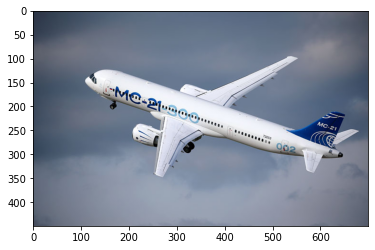

In [ ]:
# Load an image for recognition
#image = Image.open(path+dictionary_np[907].split()[0])
image = Image.open(path+'test/plane3.jpg')
plt.imshow(image)

(1, 416, 416, 3)


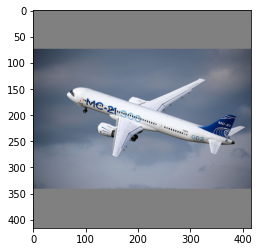

In [ ]:
# Resize the picture to fit the input_shape
iw, ih = image.size
w, h = input_shape[:2]
scale = min(w / iw, h / ih)
nw = int(iw * scale)
nh = int(ih * scale)
image_for_predict = image.resize((nw, nh), Image.BICUBIC)
new_image = Image.new('RGB', input_shape[:2], (128, 128, 128))
new_image.paste(image_for_predict, ((w - nw) // 2, (h - nh) // 2))
image_for_predict = new_image 
image_for_predict = np.array(image_for_predict) / 255.
plt.imshow(image_for_predict)
image_for_predict = image_for_predict.reshape(1, input_shape[0], input_shape[1], 3)
print (image_for_predict.shape)

In [ ]:
# Predict the image
predict = retinanet_model.predict_on_batch(image_for_predict)
regressor_out = predict[0]
classifier_out = predict[1]
print(regressor_out.shape)
print(classifier_out.shape)
regressor_out = regressor_out.reshape(-1, regressor_out.shape[2])
classifier_out = classifier_out.reshape(-1, classifier_out.shape[2])
print(regressor_out.shape)
print(classifier_out.shape)

(1, 32526, 4)
(1, 32526, 1)
(32526, 4)
(32526, 1)


In [ ]:
# Get the outputs from the 5 levels of the RetinaNet pyramid
levels = [retinanet_model.get_layer(x).output for x in ['OUT_1', 'OUT_2', 'OUT_3', 'OUT_4', 'OUT_5']]
print(levels[0])
print(levels[1])
print(levels[2])
print(levels[3])
print(levels[4])

KerasTensor(type_spec=TensorSpec(shape=(None, 52, 52, 256), dtype=tf.float32, name=None), name='OUT_1/BiasAdd:0', description="created by layer 'OUT_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 26, 26, 256), dtype=tf.float32, name=None), name='OUT_2/BiasAdd:0', description="created by layer 'OUT_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 13, 13, 256), dtype=tf.float32, name=None), name='OUT_3/BiasAdd:0', description="created by layer 'OUT_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 256), dtype=tf.float32, name=None), name='OUT_4/BiasAdd:0', description="created by layer 'OUT_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 256), dtype=tf.float32, name=None), name='OUT_5/BiasAdd:0', description="created by layer 'OUT_5'")


In [ ]:
anchors = np.zeros((0,4))
for idx, p in enumerate(levels): 
    sub_anchors = np.zeros((num_anchors, 4)) 

    sub_anchors[:, 2:] = AnchorParameters['sizes'][idx] * np.tile(AnchorParameters['scales'], 
                                                                  (2, len(AnchorParameters['ratios']))).T        
    areas = sub_anchors[:, 2] * sub_anchors[:, 3] 
      
    sub_anchors[:, 2] = np.sqrt(areas / np.repeat(AnchorParameters['ratios'], len(AnchorParameters['scales'])))
    sub_anchors[:, 3] = sub_anchors[:, 2] * np.repeat(AnchorParameters['ratios'], len(AnchorParameters['scales']))  

    sub_anchors[:, 0::2] -= np.tile(sub_anchors[:, 2] * 0.5, (2, 1)).T
    sub_anchors[:, 1::2] -= np.tile(sub_anchors[:, 3] * 0.5, (2, 1)).T
    

    grid_x = (np.arange(0, int(levels[idx].shape[2])) + 0.5) * AnchorParameters['strides'][idx]
    grid_y = (np.arange(0, int(levels[idx].shape[1])) + 0.5) * AnchorParameters['strides'][idx]
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)
    grid = np.vstack((
                        grid_x.ravel(), grid_y.ravel(),
                        grid_x.ravel(), grid_y.ravel()
                      )).transpose()
    A = sub_anchors.shape[0]
    K = grid.shape[0]

    shifted_anchors = (sub_anchors.reshape((1, A, 4)) + grid.reshape((1, K, 4)).transpose((1, 0, 2)))
    shifted_anchors = shifted_anchors.reshape((K * A, 4))

    anchors = np.append(anchors, shifted_anchors, axis = 0)    
print (anchors.shape)

(32526, 4)


In [ ]:
mean = [0, 0, 0, 0]
std = [0.2, 0.2, 0.2, 0.2]

width = anchors[:, 2] - anchors[:, 0] 
height = anchors[:, 3] - anchors[:, 1] 

Xmin = anchors[:, 0] + (regressor_out[:, 0] * std[0] + mean[0]) * width
Ymin = anchors[:, 1] + (regressor_out[:, 1] * std[1] + mean[1]) * height
Xmax = anchors[:, 2] + (regressor_out[:, 2] * std[2] + mean[2]) * width
Ymax = anchors[:, 3] + (regressor_out[:, 3] * std[3] + mean[3]) * height

Xmin = np.clip(Xmin, 0, input_shape[0] - 1)
Ymin = np.clip(Ymin, 0, input_shape[1] - 1)
Xmax = np.clip(Xmax, 0, input_shape[0] - 1)
Ymax = np.clip(Ymax, 0, input_shape[1] - 1)

prediction_box = np.stack([Xmin, Ymin, Xmax, Ymax], axis=1)
print (prediction_box.shape)

(32526, 4)


In [ ]:
score_threshold = 0.3
true_boxes = prediction_box[np.where(classifier_out > score_threshold)[0]]
true_scores = classifier_out[np.where(classifier_out > score_threshold)[0]].flatten()

In [ ]:
# Non-Maximum Suppression
def compute_iou(box, boxes, box_area, boxes_area):
    assert boxes.shape[0] == boxes_area.shape[0]
    ys1 = np.maximum(box[0], boxes[:, 0])
    xs1 = np.maximum(box[1], boxes[:, 1])
    ys2 = np.minimum(box[2], boxes[:, 2])
    xs2 = np.minimum(box[3], boxes[:, 3])
    intersections = np.maximum(ys2 - ys1, 0) * np.maximum(xs2 - xs1, 0)
    unions = box_area + boxes_area - intersections
    ious = intersections / unions
    return ious

ys1 = true_boxes[:, 0] 
xs1 = true_boxes[:, 1]
ys2 = true_boxes[:, 2]
xs2 = true_boxes[:, 3]

areas = (ys2 - ys1) * (xs2 - xs1)

scores_indexes = true_scores.argsort().tolist()
boxes_keep_index = [] 
while len(scores_indexes): 
    index = scores_indexes.pop() 
    boxes_keep_index.append(index) 
    if not len(scores_indexes):
        break        
    ious = compute_iou(true_boxes[index], true_boxes[scores_indexes], areas[index],
                       areas[scores_indexes]) 
    filtered_indexes = set((ious > 0.2).nonzero()[0]) 
    scores_indexes = [
        v for (i, v) in enumerate(scores_indexes)
        if i not in filtered_indexes
    ] 
result_box = np.array(boxes_keep_index)  
print (result_box.shape) 

(1,)


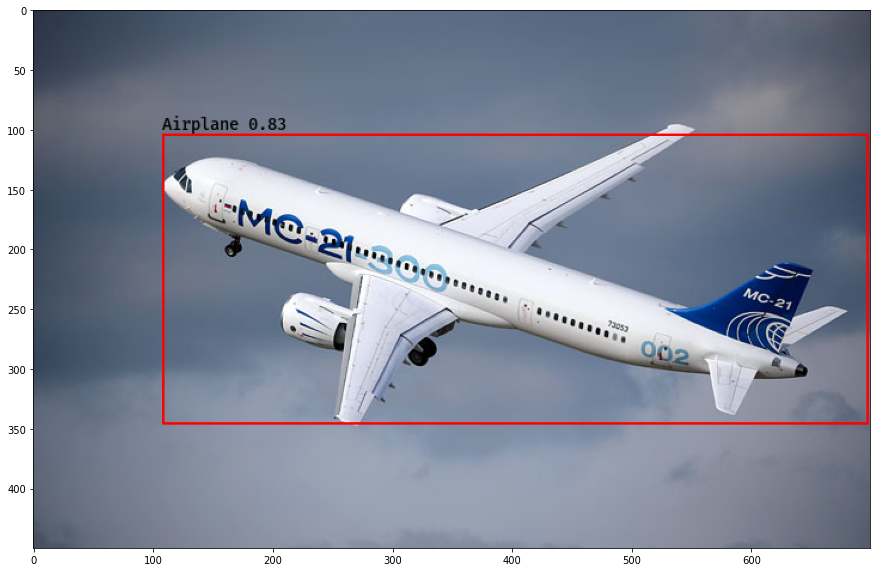

In [ ]:
from PIL import ImageFont
show_image = image.copy()

for idx, elem in enumerate(result_box):
    box = true_boxes[elem].copy()
    iw, ih = image.size
    w, h = input_shape[:2]
    scale = min(w/iw, h/ih)
    offset = [(w - nw) // 2, (h - nh) // 2]
    box [:2] = box[:2] - offset
    box [-2:] = box[-2:] - offset
    box /= scale
    left, top, right, bottom = box
    font = ImageFont.truetype(font=path+'font.otf',
                        size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    import cv2    
    draw = ImageDraw.Draw(show_image)
    label = '{} {:.2f}'.format(name_classes[0], true_scores[elem])
    label_size = draw.textsize(label, font)
    for i in range(2):
        draw.rectangle(
          [left + i, top + i, right - i, bottom - i],
          outline='red')
    if top - label_size[1] >= 0:
        text_origin = np.array([left, top - label_size[1]])
    else:
        text_origin = np.array([left, top + 1])
    draw.text(text_origin, label, fill=(0, 0, 0), font=font)
plt.figure(figsize=(15, 15))
plt.imshow(show_image)
plt.show()
show_image.save('new_image.jpg')